**Course website**: http://lagex.github.io/geofisica2

**Note**: This notebook is part of the course "Geofísica 2" of Geology program of the 
[Universidade do Estado do Rio de Janeiro](http://www.uerj.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)

Esse documento que você está usando é um [IPython notebook](http://ipython.org/notebook.html). É um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (que pode ser números, texto, figuras, videos, etc).

# Prática 5 - Sísmica de refração

Nessa prática vamos simular uma aquisição de sísmica de refração. A aquisição será feita para determinar a espessura de uma camada e as velocidades da onda P nessa camada e no meio abaixo. Nesse caso, a camada é a crosta e o meio abaixo é o manto, ou seja, estamos buscando a profundidade da Moho. Em seguida, utilizaremos outro modelo com duas camadas: uma bacia sedimentar e a crosta abaixo dela.

Após a simulação, vamos utilizar os dados gerados para fazer uma modelagem direta para determinar a espessura das camadas e as velocidades da onda sísmica (P).

Utilizaremos as simulações de ondas da biblioteca [Fatiando a Terra](http://www.fatiando.org). Essas simulações utilizam o [método de diferenças finitas](http://en.wikipedia.org/wiki/Finite_difference_method) para calcular soluções da equação da onda.

As tarefas abaixo acompanham as questões que vocês devem responder. Usem as simulações abaixo para te ajudar a responder as perguntas.

## Preparação

Rode a célula abaixo para carregar as componentes necessárias para fazer as simulações. Não se preocupe se aparecer um `:0: FutureWarning: IPython widgets are experimental and may change in the future.` abaixo. Isso é consequência de utilizar tecnologia de ponta.

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from IPython.html import widgets
from IPython import display
from fatiando import utils
from fatiando.seismic.wavefd import Ricker, ElasticPSV, ElasticSH
from fatiando.vis import mpl
import fatiando
plt.rc('font', size=12)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Simulação de uma única interface

Rode as células abaixo para simular uma aquisição sísmica de refração em um modelo com uma única interface. Essa interface será a Moho.

In [2]:
shape = (200, 800)
spacing = 500
densidade = np.ones(shape)*2700
velocidade = np.ones(shape)*3200
l1 = 50e3//spacing
densidade[l1:,:] = 3300
velocidade[l1:,:] = 5000

In [3]:
sim = ElasticSH(velocidade, densidade, spacing=spacing, taper=0.003, padding=80)
sim.add_point_source((0, 100), Ricker(5, 0.5, 1/0.5))

In [4]:
sim.run(3000)

|##################################################|100% Ran 3000 iterations in 77.8605 seconds.

In [5]:
sim.animate(every=30, embed=True, dpi=70, fps=7, cutoff=0.0001, cmap="Greys")

## Aquisição de dados de refração

A simulação representa um tiro feito na superfície. Agora precisamos extrair os dados que seriam **observados por sismômetros na superfície**. Os sismômetros estão expalhados da fonte até o final da área, como mostra o esquema abaixo:

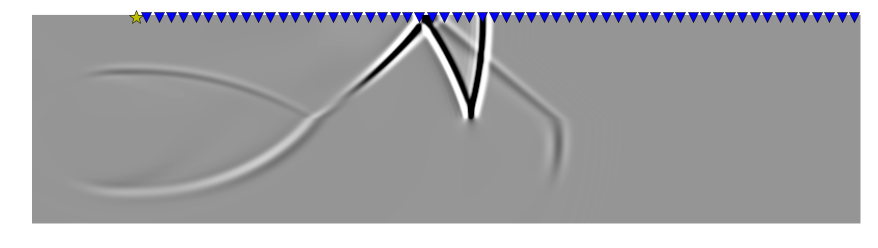

In [10]:
plt.figure(figsize=(12, 4))
ax = plt.subplot(111)
ax.axison = False
ax.imshow(sim[1500], cmap='Greys', vmin=-1e-4, vmax=1e-4)
plt.plot(100, 0, '*y', markersize=15)
recs = np.arange(110, shape[1], 12)
plt.plot(recs, np.zeros_like(recs), 'vb', markersize=10)
plt.xlim(0, shape[1])
plt.ylim(shape[0], -10)
plt.tight_layout(pad=0)

Rode as células abaixo para extrair os dados da simulação e gerar um gráfico.

In [11]:
dados_moho = sim[:, 0, 100::5]
distancia = np.linspace(0, spacing*shape[1] - spacing*100, dados_moho.shape[1])
tempo = np.linspace(0, sim.dt*(sim.it + 1), sim.it + 1)
extent = (distancia[0]/1000, distancia[-1]/1000, tempo[-1], 0)

In [12]:
def plota_dados(dados, distancia, tempo, scale=0.00004, ax=None):
    if ax is None:
        plt.figure(figsize=(10, 4))
        ax = plt.subplot(111)
    plt.pcolormesh(distancia/1000, tempo, dados, cmap="Greys", vmin=-scale, vmax=scale)
    plt.xlabel(u'distância da fonte (km)')
    plt.ylabel('tempo (s)')
    plt.ylim(tempo.min(), tempo.max())
    plt.tight_layout()

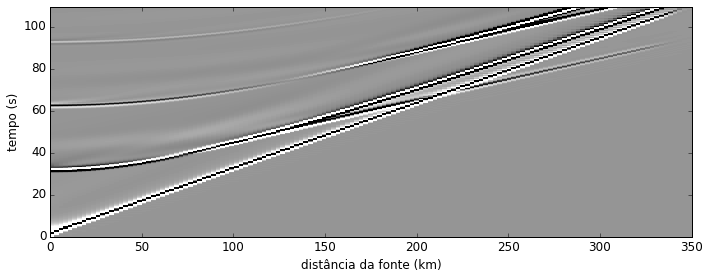

In [13]:
plota_dados(dados_moho, distancia, tempo)

Os tons de cinza no gráfico acima representam a direção de oscilação da onda. Escuro representa deslocamento para cima. Branco, para baixo. Cada tira vertical representa o sismograma de um sismômetro localizado naquela coordenada x. Esse conjunto de sismogramas, um ao lado do outro, é chamado de **seção sísmica**. Veremos vários desses de agora em diante.

## Modelagem direta para uma interface (Moho)

Vamos fazer a modelagem direta dos dados acima para determinar a espessura da camada ($h$) e as velocidades das ondas sísmicas na camada ($v_1$) e no meio abaixo ($v_2$). As fórmulas para calcular os tempos de chegada como função da distância ($d$) das ondas direta ($t_d$) e refratada ($t_t$) são: 

$$
t_d = \frac{d}{v_1}
$$

e 

$$
t_t = \frac{d}{v_2} + \frac{2 h \cos i_c}{v_1}
$$

Rode a célula abaixo para gerar o gráfico interativo da modelagem.

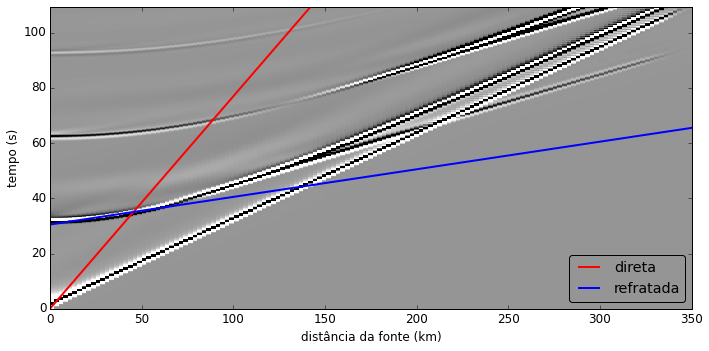

In [14]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
tmp = np.zeros_like(distancia)
plot_td, = ax.plot(distancia/1000, tmp, '-r', label='direta', linewidth=2)
plot_tr, = ax.plot(distancia/1000, tmp, '-b', label='refratada', linewidth=2)
plt.legend(loc='lower right', fancybox=True)
plota_dados(dados_moho, distancia, tempo, ax=ax)

def modelo_1_camada(h, v1, v2):
    td = distancia/v1
    cos_critico = np.cos(np.arcsin(v1/v2))
    tr = distancia/v2 + 2*h*cos_critico/v1
    plot_td.set_ydata(td)
    plot_tr.set_ydata(tr)
    display.display(fig)
    
widgets.interactive(modelo_1_camada,
                    h=widgets.FloatSliderWidget(min=1e3, max=100e3, step=1e3, value=20e3),
                    v1=widgets.FloatSliderWidget(min=500, max=10000, step=100, value=1000),
                    v2=widgets.FloatSliderWidget(min=500, max=10000, step=100, value=10000))

A figura acima mostra a seção sísmica que extraímos e duas retas: o tempo de chegada da onda direta (vermelho) e o tempo de chegada da onda refratada (azul). Os botões controlam a espessura da camada (crosta) e as velocidades na camada e abaixo (crosta e manto).

**Determine a espessura da Moho e as velocidades da onda P na crosta e no manto.**

## Simulação de duas interfaces (bacia-embasamento e Moho)

Vamos simular uma situação mais complexa. Agora serão duas interfaces: entre uma bacia sedimentar e o empasamento cristalino e entre a crosta e o manto.

Rode as células abaixo para executar a simulação.

In [6]:
shape = (200, 800)
spacing = 500
extent = [0, shape[1]*spacing, shape[0]*spacing, 0]
densidade = np.ones(shape)*1800
velocidade = np.ones(shape)*2000
l = 10e3//spacing
densidade[l:,:] = 2700
velocidade[l:,:] = 3500
l = 50e3//spacing
densidade[l:,:] = 3300
velocidade[l:,:] = 5000

In [7]:
sim2 = ElasticSH(velocidade, densidade, spacing=spacing, taper=0.003, padding=80)
sim2.add_point_source((0, 100), Ricker(5, 0.5, 1/0.5))

In [8]:
sim2.run(3000)

|##################################################|100% Ran 3000 iterations in 77.6538 seconds.

In [9]:
sim2.animate(every=30, embed=True, dpi=70, fps=7, cutoff=0.00005, cmap="Greys")

## Aquisição de dados para duas interfaces

Vamos fazer a aquisição dos dados da mesma forma que para o exercício de uma interface. Os sismômetros estão na superfície, indo da fonte até o final da área.

Rode as células abaixo para extrair os dados da simulação e gerar a seção sísmica.

In [15]:
dados_moho_bacia = sim2[:, 0, 100::5]

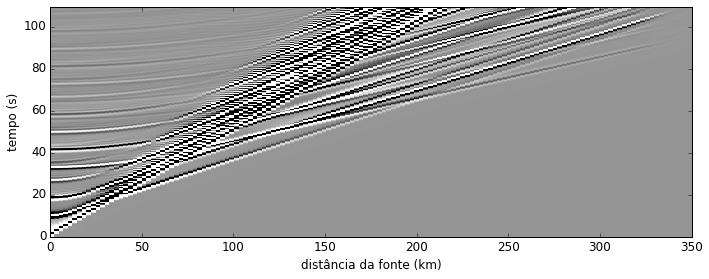

In [16]:
plota_dados(dados_moho_bacia, distancia, tempo)

Note que os dados são bem mais complexos que anteriormente com várias refrações e reflexões.

## Modelagem direta para duas camadas

Agora que temos os dados, podemos fazer nossa modelagem direta para determinar as duas interfaces. Os tempos de chegada para esse modelo são:

$$
t_d = \frac{d}{v_1}
$$ 

$$
t_{t1} = \frac{d}{v_2} + \frac{2 h_1 \cos i_{c1}}{v_1}
$$

e

$$
t_{t2} = \frac{d}{v_3} + \frac{2 h_1 \cos i_{c1}}{v_1} + \frac{2 h_2 \cos i_{c2}}{v_2}
$$


Rode a célula abaixo para gerar a figura interativa. Determine as espessuras das camadas e as velocidades da onda P.

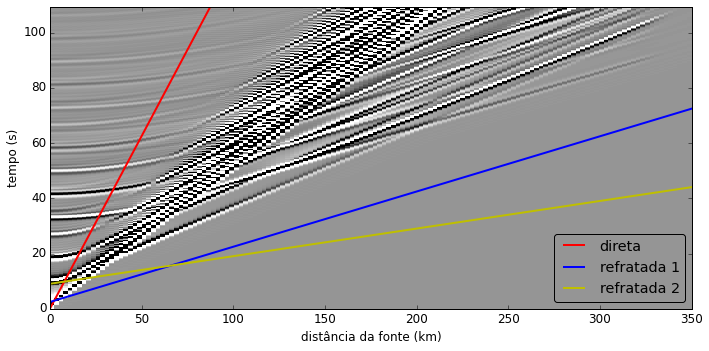

In [17]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
tmp = np.zeros_like(distancia)
plt_td, = ax.plot(distancia/1000, tmp, '-r', label='direta', linewidth=2)
plt_tr1, = ax.plot(distancia/1000, tmp, '-b', label='refratada 1', linewidth=2)
plt_tr2, = ax.plot(distancia/1000, tmp, '-y', label='refratada 2', linewidth=2)
plt.legend(loc='lower right', fancybox=True)
plota_dados(dados_moho_bacia, distancia, tempo, ax=ax)

def modelo_1_camada(h1, h2, v1, v2, v3):
    # h2 deveria ser a espessura da segunda camada
    # O que eu estou modelando é a profuncidade da camada
    # Então a espessura é a profundidade menos a espessura da de cima
    h2 -= h1
    td = distancia/v1
    cos_critico12 = np.cos(np.arcsin(v1/v2))
    tr1 = distancia/v2 + 2*h1*cos_critico12/v1
    critico23 = np.arcsin(v2/v3)
    tr2 = distancia/v3 + 2*h1*cos_critico12/v1 + 2*h2*np.cos(critico23)/v2
    plt_td.set_ydata(td)
    plt_tr1.set_ydata(tr1)
    plt_tr2.set_ydata(tr2)
    display.display(fig)
    
widgets.interactive(modelo_1_camada,
                    h1=widgets.FloatSliderWidget(min=1e3, max=100e3, step=1e3, value=1e3),
                    h2=widgets.FloatSliderWidget(min=1e3, max=100e3, step=1e3, value=20e3),
                    v1=widgets.FloatSliderWidget(min=500, max=10000, step=100, value=500),
                    v2=widgets.FloatSliderWidget(min=500, max=10000, step=100, value=5000),
                    v3=widgets.FloatSliderWidget(min=500, max=10000, step=100, value=10000)) 